In [1]:
from transformers import BertTokenizer, BertModel, AlbertTokenizerFast, AlbertModel
import torch
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading + making equations

In [2]:
def get_equation(reaction,reaction_rate):
    neg, delim ,pos =re.split(r'(<->|->|<-)', reaction, maxsplit=1)
    all_terms = ["-" + term for term in neg.split("+")]
    all_terms.extend(pos.split("+"))
    all_terms.append(reaction_rate)
    equation = (" = ".join(all_terms)).replace(" null =","")
    return equation

In [3]:
data = pd.read_csv("dataframe.csv", index_col=0)
data['equations'] = data.apply(lambda row: get_equation(row['reactions'], row['reaction_rates']), axis=1)
data

,reactions,reaction_rates,desc,equations
1,[Blood-Lymph].CTLA4_mabB <-> Lymph_Node.CTLA4_mab,Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTL...,Distribution of Anti-CTLA-4 mAb between the ce...,-[Blood-Lymph].CTLA4_mabB = Lymph_Node.CTLA4...
2,[Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_...,0.67*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma1_CT...,Distribution of Anti-CTLA-4 mAb between the ce...,-[Blood-Lymph].CTLA4_mabB = Peripheral.CTLA4...
3,[Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_...,0.33*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma2_CT...,Distribution of Anti-CTLA-4 mAb between the ce...,-[Blood-Lymph].CTLA4_mabB = Peripheral.CTLA4...
4,[Blood-Lymph].CTLA4_mabB <-> Tumor.CTLA4_mabt,Kpa_TB*S_TB*Vt_avg_const*[Blood-Lymph].CTLA4_m...,Distribution of Anti-CTLA-4 mAb between the ce...,-[Blood-Lymph].CTLA4_mabB = Tumor.CTLA4_mabt...
5,[Blood-Lymph].CTLA4_mabB -> null,Cl_CTLA4*[Blood-Lymph].CTLA4_mabB,Clearance of Anti-CTLA-4 mAb from the central ...,-[Blood-Lymph].CTLA4_mabB = Cl_CTLA4*[Blood-...
6,[Blood-Lymph].Effector_T_TB -> [Blood-Lymph].E...,EffT_Migrate*[Blood-Lymph].Effector_T_TB,The generation of Effector T cells and their m...,-[Blood-Lymph].Effector_T_TB = [Blood-Lymph]...
7,[Blood-Lymph].Effector_TB -> Liv_Spln_GI.EffT_...,QC_GI*[Blood-Lymph].Effector_TB/Vc_Teff,Trafficking of free Effector T cells from bloo...,-[Blood-Lymph].Effector_TB = Liv_Spln_GI.Eff...
8,[Blood-Lymph].Effector_TB -> Liv_Spln_GI.EffT_...,(QC_Liver-QC_GI-QC_Spleen+LC_GI+LC_Spleen)*[Bl...,Trafficking of free Effector T cells from bloo...,-[Blood-Lymph].Effector_TB = Liv_Spln_GI.Eff...
9,[Blood-Lymph].Effector_TB -> Liv_Spln_GI.EffT_...,QC_Spleen * [Blood-Lymph].Effector_TB/Vc_Teff,Trafficking of free Effector T cells from bloo...,-[Blood-Lymph].Effector_TB = Liv_Spln_GI.Eff...
10,[Blood-Lymph].Effector_TB -> Lymph_Node.EffT_L...,QC_LN*[Blood-Lymph].Effector_TB/Vc_Teff,Trafficking of free Effector T cells from bloo...,-[Blood-Lymph].Effector_TB = Lymph_Node.EffT...


In [4]:
data['equations'][1]

'-[Blood-Lymph].CTLA4_mabB  =  Lymph_Node.CTLA4_mab = Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTLA4_mabB/Vc_CTLA4-Lymph_Node.CTLA4_mab/VL)'

### Getting the Embeddings

In [6]:
def get_bert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    model = BertModel.from_pretrained(model_path)
    return tokenizer, model

def get_albert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = AlbertTokenizerFast.from_pretrained(tokenizer_path)
    model = AlbertModel.from_pretrained(model_path)
    return tokenizer, model

def get_embedding(tokenizer, model, text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():  
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings


In [7]:
math_albert_path = "AnReu/albert-for-arqmath-3"
desc_bert_path = "bert-base-uncased"

In [8]:
mtokenizer, mmodel = get_albert_tokenizer_and_model(math_albert_path, math_albert_path)
dtokenizer, dmodel = get_bert_tokenizer_and_model(desc_bert_path, desc_bert_path)

Some weights of the model checkpoint at AnReu/albert-for-arqmath-3 were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
rcn_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['equations']])
rate_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in data['desc']])
eq_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['equations']])
desc_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in data['desc']])

### Cosine Similarity as a sanity check

In [17]:
eq_sim = cosine_similarity(eq_embs,eq_embs)
desc_sim = cosine_similarity(desc_embs, desc_embs)

Text(0.5, 1.0, 'Similarity of Equations')

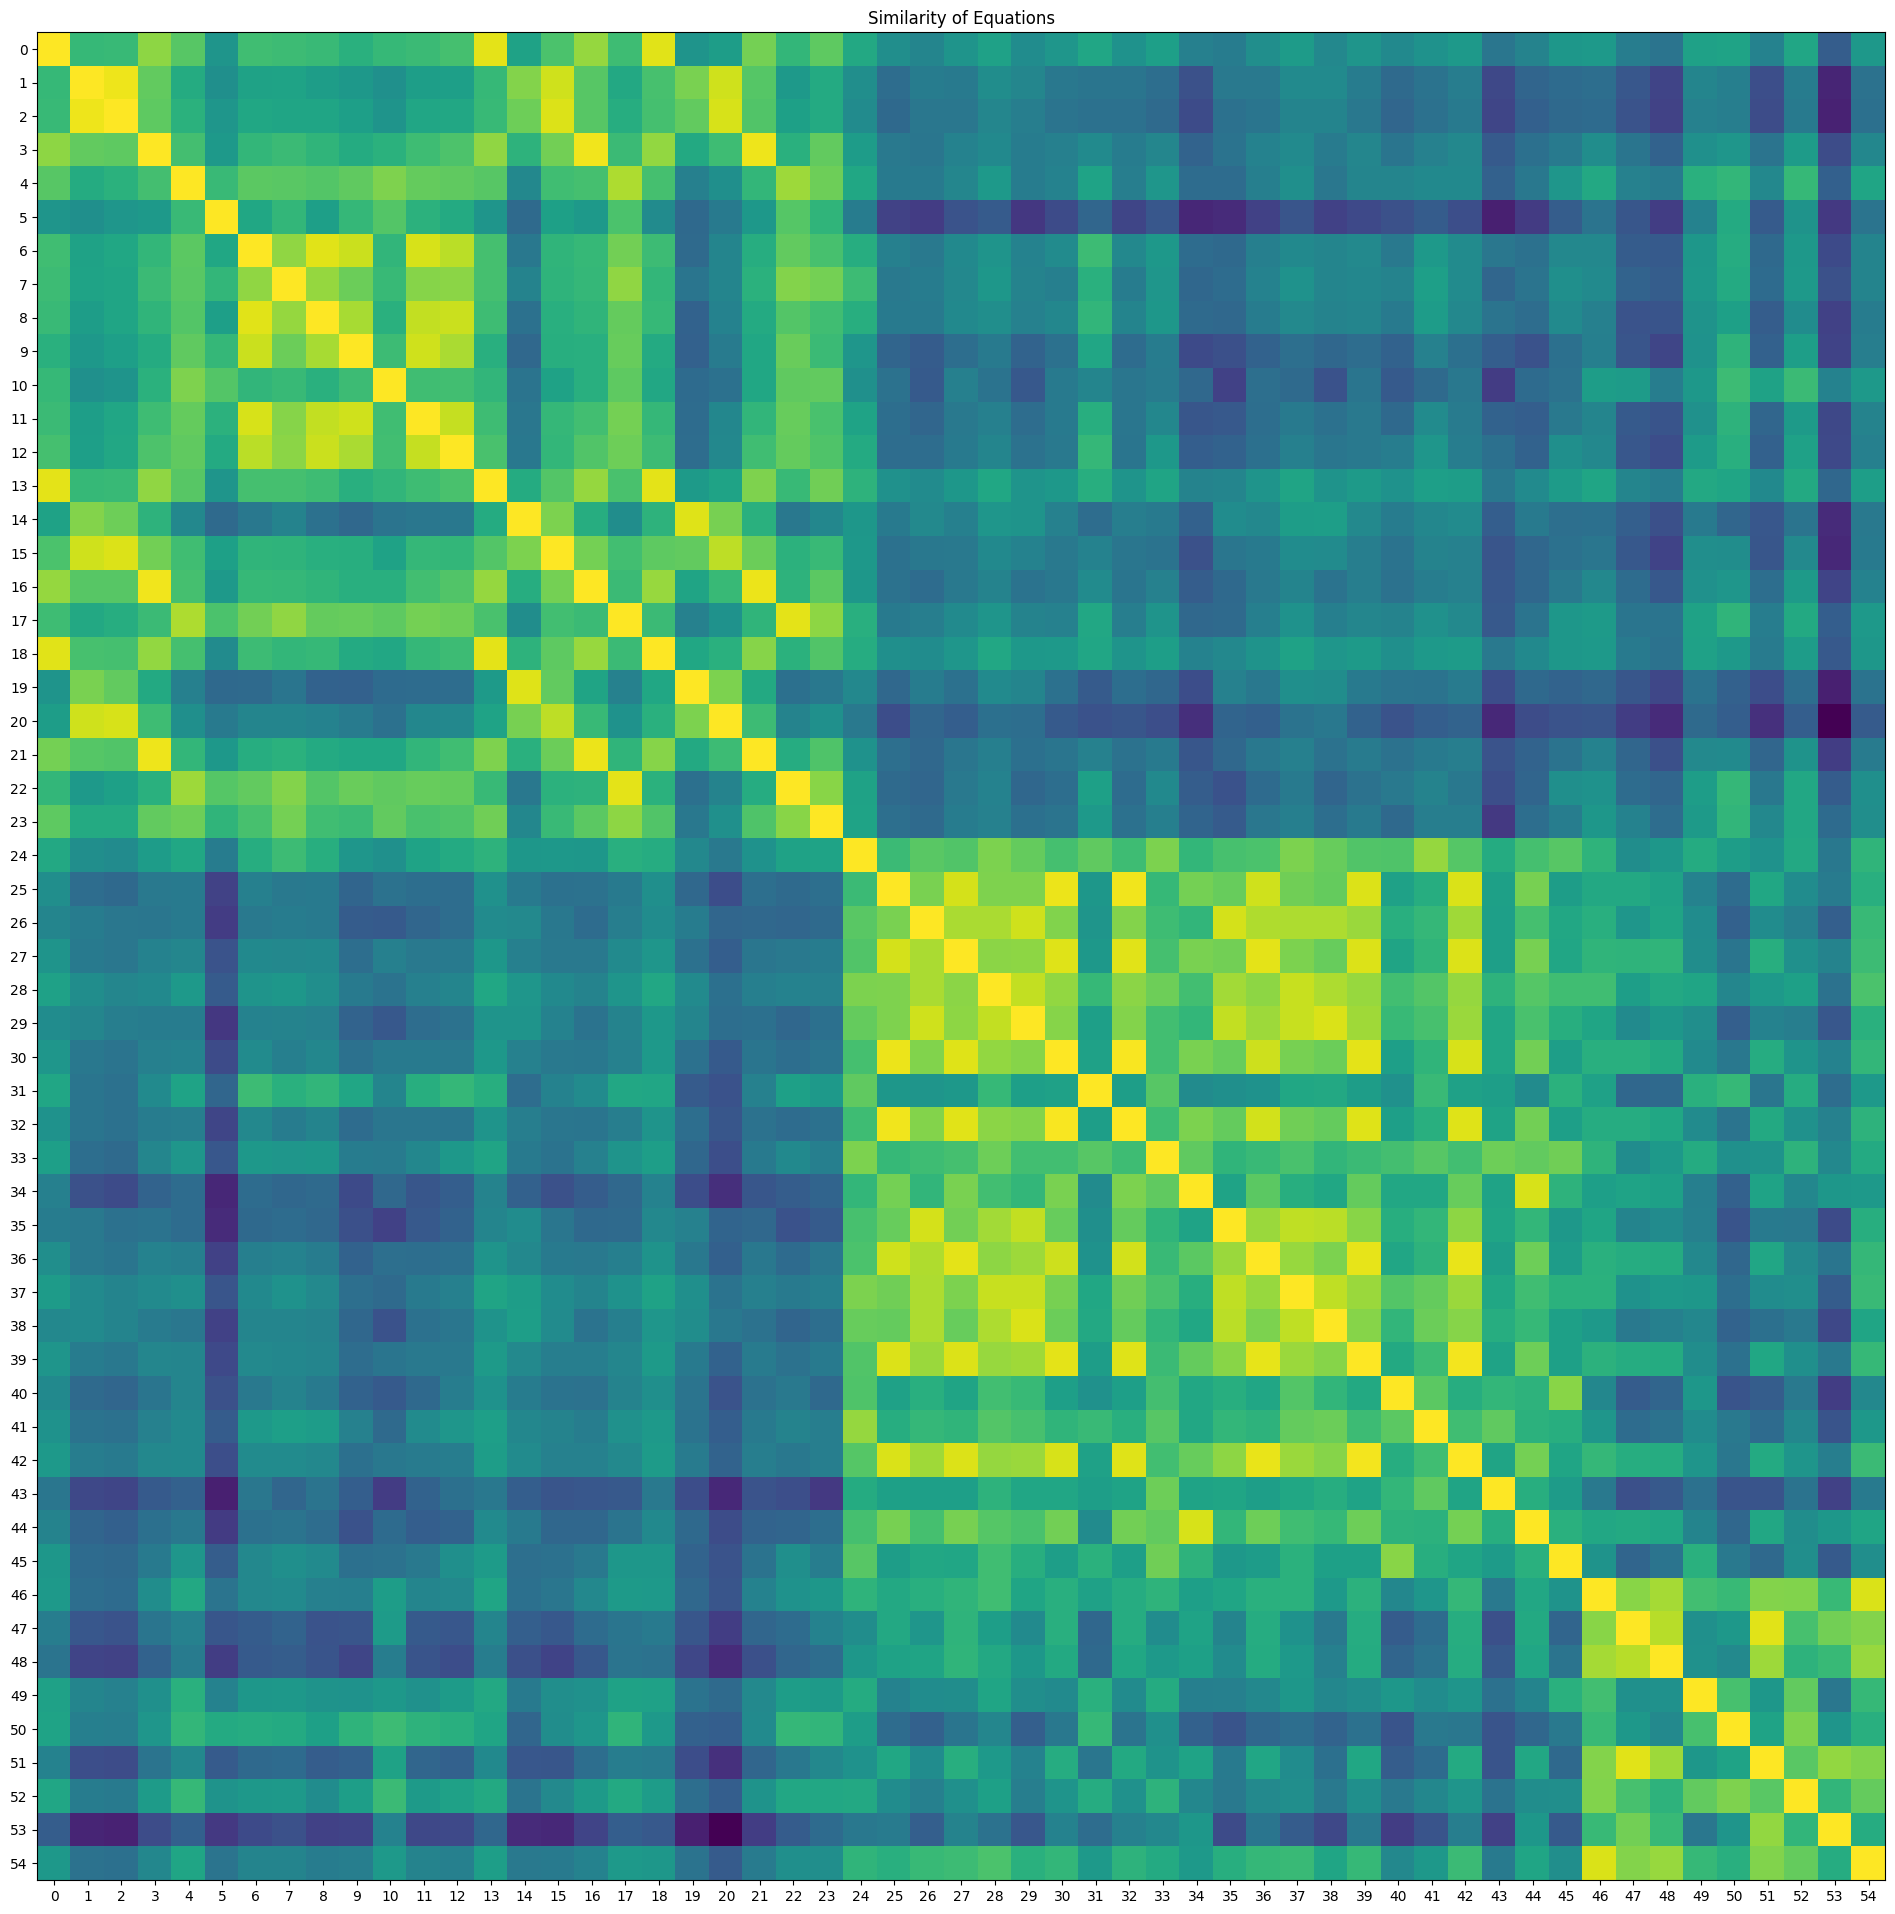

In [18]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(eq_sim)
plt.title("Similarity of Equations")

Text(0.5, 1.0, 'Similarity of Descriptions')

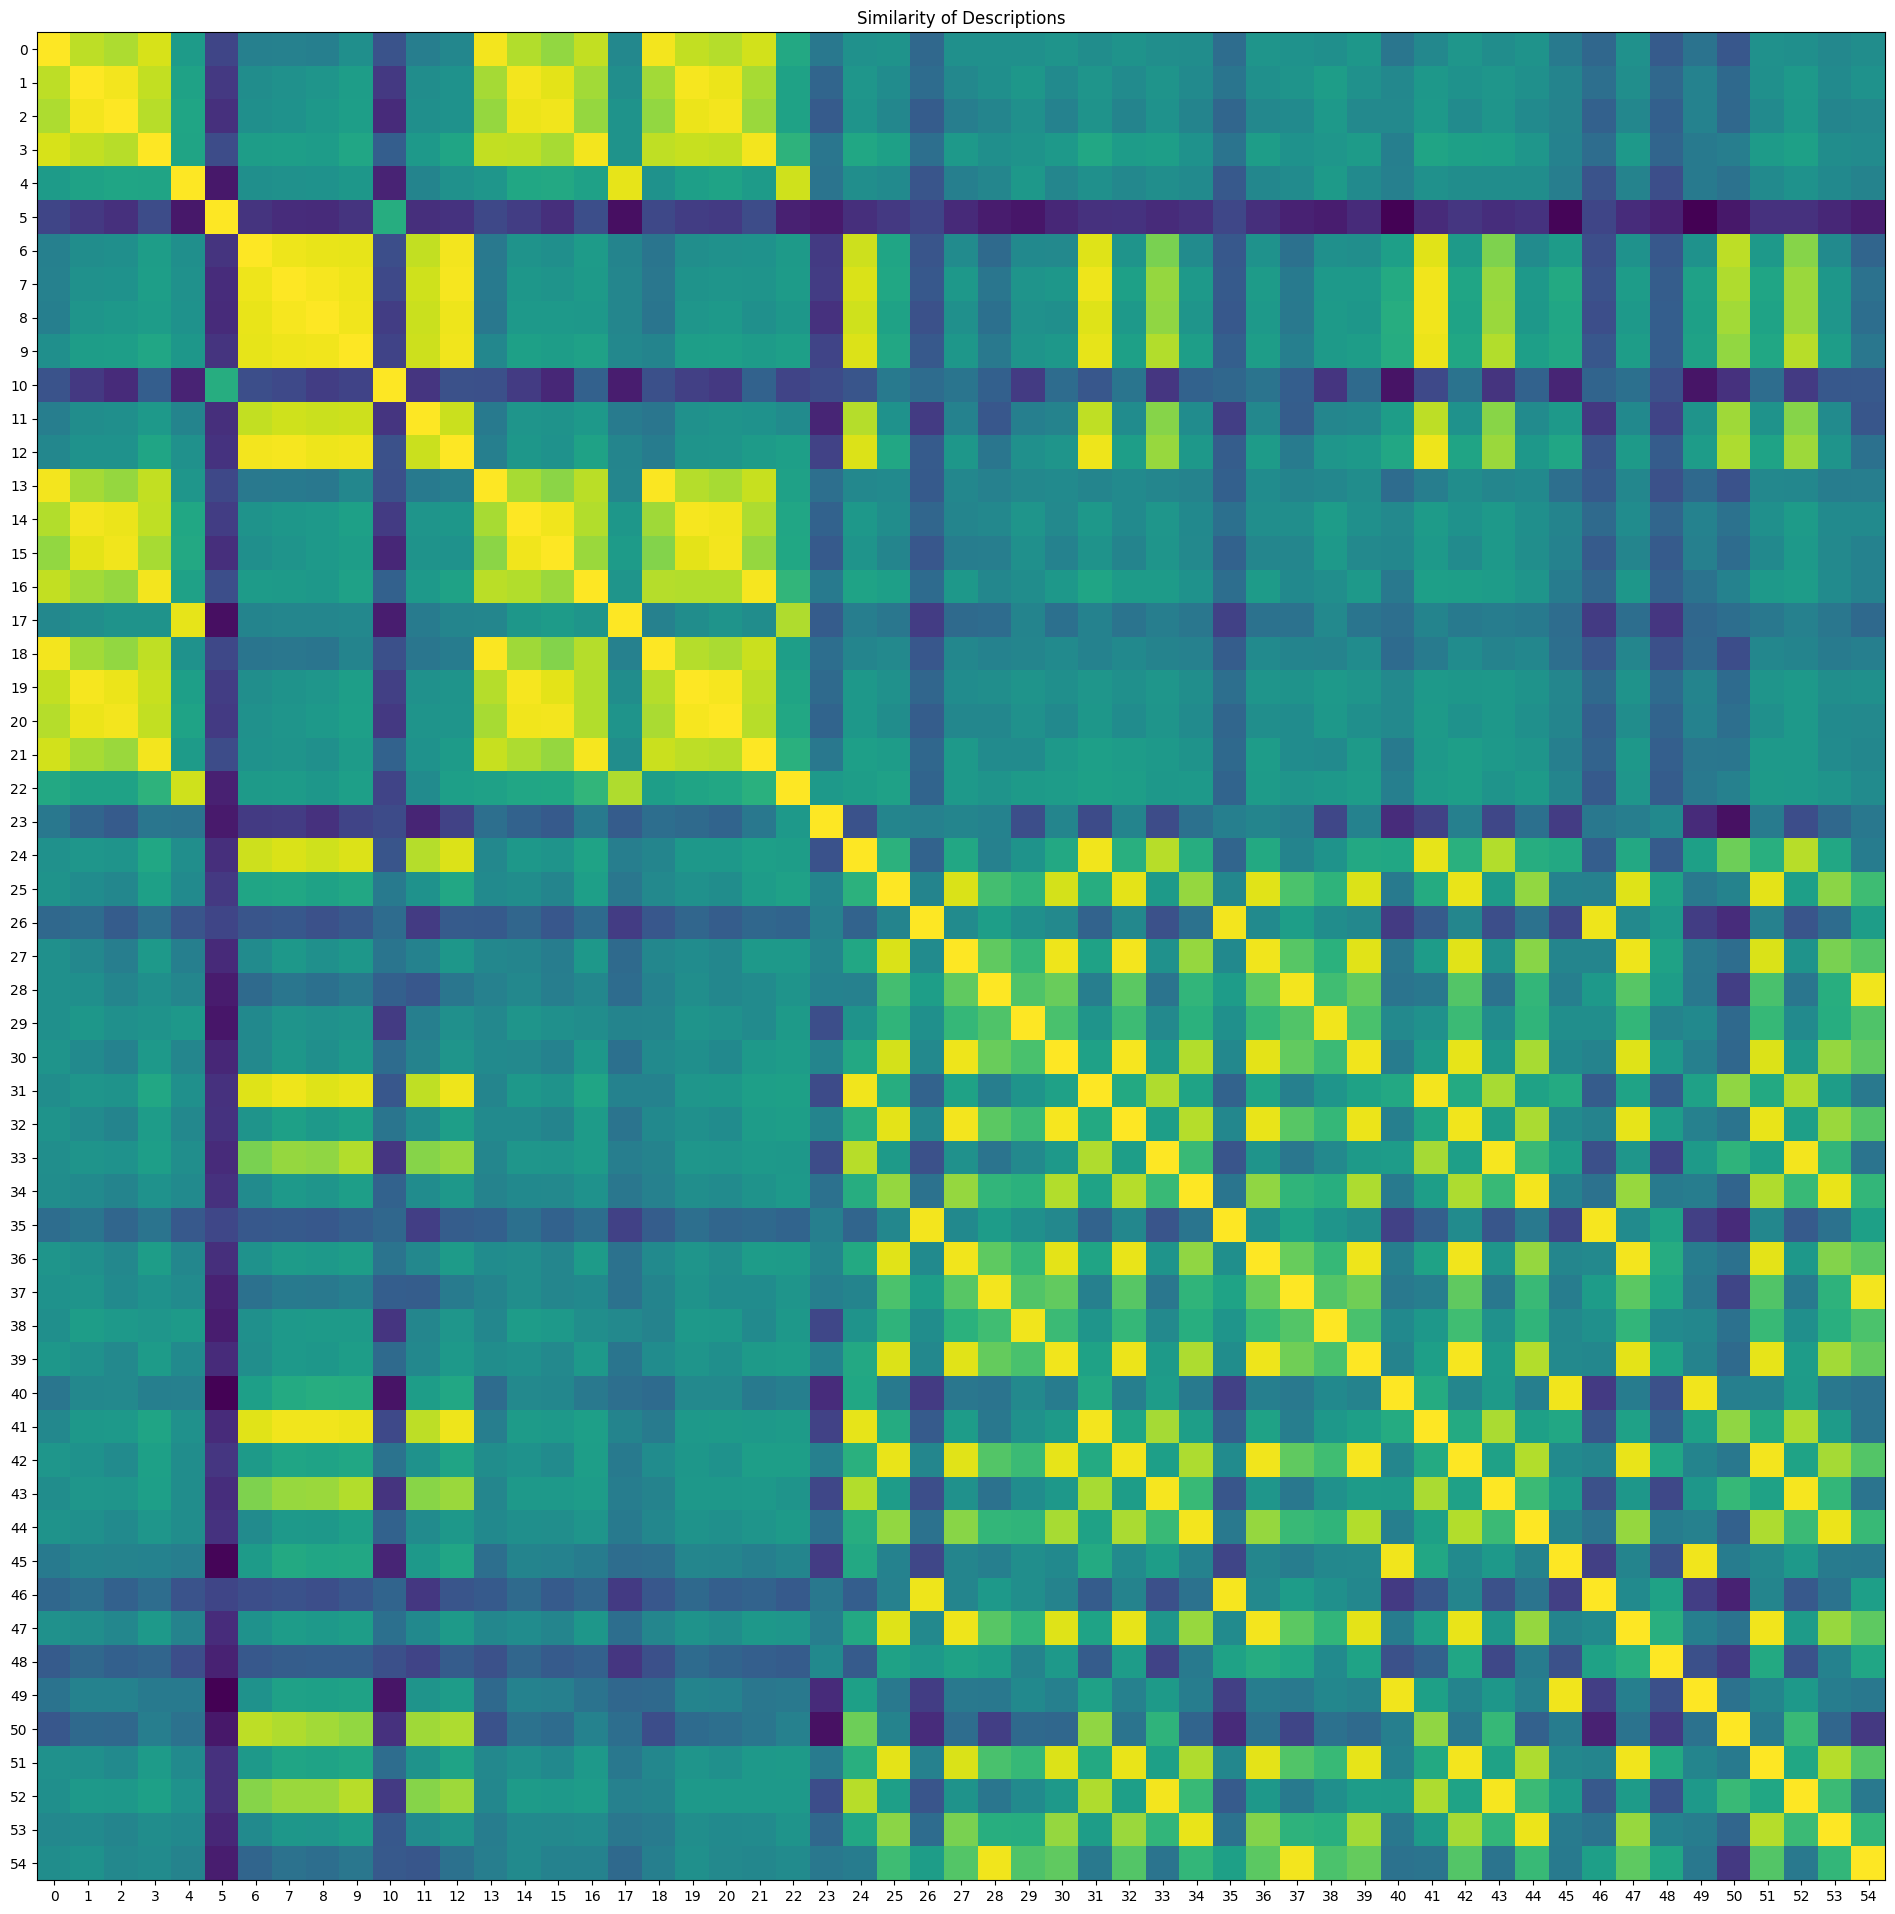

In [19]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(desc_sim)
plt.title("Similarity of Descriptions")

### Lets try some visualization to see if things cluster nicely - TSNE?

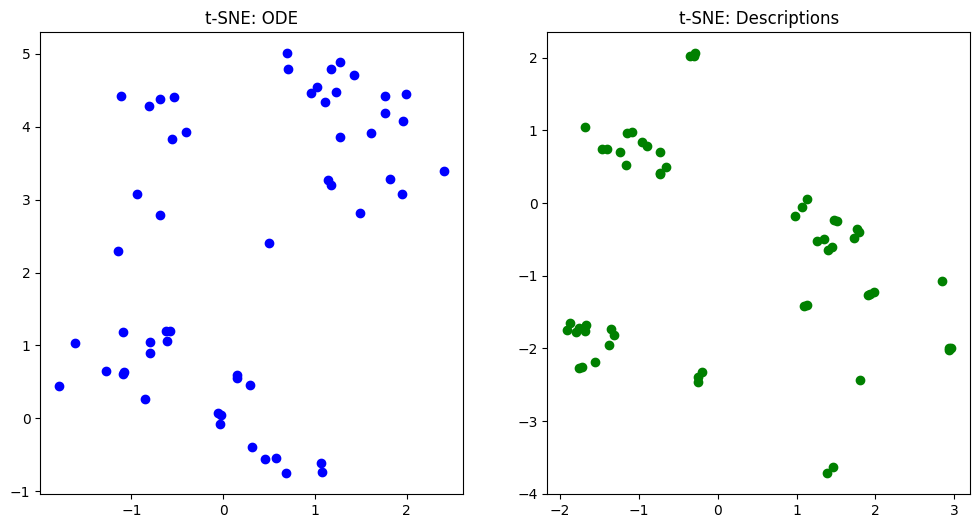

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE on math equations (Set A)
tsne_A = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_A = tsne_A.fit_transform(eq_embs)

# t-SNE on descriptions (Set B)
tsne_B = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_B = tsne_B.fit_transform(desc_embs)

# Plot
plt.figure(figsize=(12, 6))

# Plot Set A (math equations)
plt.subplot(1, 2, 1)
plt.scatter(tsne_embeddings_A[:, 0], tsne_embeddings_A[:, 1], color='blue', label='Equations')
plt.title("t-SNE: ODE")

# Plot Set B (descriptions)
plt.subplot(1, 2, 2)
plt.scatter(tsne_embeddings_B[:, 0], tsne_embeddings_B[:, 1], color='green', label='Descriptions')
plt.title("t-SNE: Descriptions")

plt.show()


### Are clusters based on  equations good predictors of description clusters?

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing

from sklearn.neighbors import NearestNeighbors
n_clusters = 5  
kmeans_A = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(eq_embs))
kmeans_B = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(desc_embs))

labels_A = kmeans_A.labels_
labels_B = kmeans_B.labels_
nn_model = NearestNeighbors(n_neighbors=1, metric='cosine')
nn_model.fit(desc_embs)
correct_matches = 0
for i, embedding_A in enumerate(eq_embs):
    distance, index = nn_model.kneighbors([embedding_A], return_distance=True)
    if labels_A[i] == labels_B[index[0][0]]:
        correct_matches += 1

accuracy = correct_matches / len(eq_embs)
print(f"Cross-modal cluster matching accuracy: {accuracy * 100:.2f}%")

Cross-modal cluster matching accuracy: 45.45%
